In [1]:
# * * * * * * * * * * * * * * * *
# Configuration
# * * * * * * * * * * * * * * * *
EXPERIMENT_NUM='6'

DATASET_DIR = '/workspace/datasets'
OUTPUT_DIR = '/workspace/outputs'

TARGET_METRIC='std_temp'
SAMPLE_SIZE=10000

DEVICE = "cpu"

LATENT_DIM=4
BATCH_SIZE=200
EPOCHS=100
BETA=0.2
LEARNING_RATE=1e-3
GAMMA=0.1

INPUT_DIM=(1,120)

In [2]:
import os
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary

from lunar_vae import VAE, train, SampleLatentSpace, VisualizeLatentSpace
from utils import (
    CollectStatisticsFromProfilesV2,
    ConvertProfileListToCsv,
    CreateProfileSubset,
    GenerateDensityPlot,
    GetDataMetrics,
    GetMeanLatentValues,
    LoadProfileList,
    LoadTemperatureDataV2,
    PlotHistograms,
    PlotComparativeHistograms,
    PlotLosses,
    PrintAndLog,
    SaveLossesToCSV,
    SetupOutputDir,
    SplitAndNormalizeData,
)

# * * * * * * * * * * * * * * * *
# Setting Variables
# * * * * * * * * * * * * * * * *
PROFILES_DIR = os.path.join(DATASET_DIR, f'profiles-v2', f'profiles-v2-jsons')
ORIGINAL_PROFILE_LIST_JSON = os.path.join(DATASET_DIR, f'profiles-v2', f'profile_list_v2.json')
LABEL = f'profiles_v2_experiment_{EXPERIMENT_NUM}'
BINNED_PROFILE_LIST = os.path.join(DATASET_DIR, 'profiles-v2', 'profile_list_v2_binned.json')

# * * * * * * * * * * * * * * * *
# Make Directory
# * * * * * * * * * * * * * * * *
model_dir = SetupOutputDir(OUTPUT_DIR, parent_folder=LABEL, sub_folders=["reconstruction_images"])
print(f"Created directory {model_dir}")

Created directory /workspace/outputs/profiles_v2_experiment_6_20250330_0143


In [3]:
# * * * * * * * * * * * * * * * *
# Create Subset by Metric
# * * * * * * * * * * * * * * * *
SUBSET_PROFILE_LIST = os.path.join(model_dir, f'profile_list_v2_{TARGET_METRIC}_{SAMPLE_SIZE}.json')
CreateProfileSubset(BINNED_PROFILE_LIST, SUBSET_PROFILE_LIST, TARGET_METRIC, SAMPLE_SIZE)

In [4]:
# * * * * * * * * * * * * * * * *
# Load Profile List
# * * * * * * * * * * * * * * * *
profile_list = LoadProfileList(SUBSET_PROFILE_LIST)

In [5]:
# * * * * * * * * * * * * * * * *
# Convert to CSV
# * * * * * * * * * * * * * * * *
csv_path = ConvertProfileListToCsv(PROFILES_DIR, profile_list, model_dir)

Processing Profiles: 100%|██████████| 248078/248078 [01:31<00:00, 2699.53it/s]

Saved 248078 profiles to /workspace/outputs/profiles_v2_experiment_6_20250330_0143/20250330-dataset.csv


In [6]:
# * * * * * * * * * * * * * * * *
# Load Temp Data
# * * * * * * * * * * * * * * * *
temp_data = LoadTemperatureDataV2(csv_path, DEVICE)

Loading Profiles: 248078it [00:14, 17007.11it/s]


Saved figure to /workspace/outputs/profiles_v2_experiment_6_20250330_0143/density_plot.png


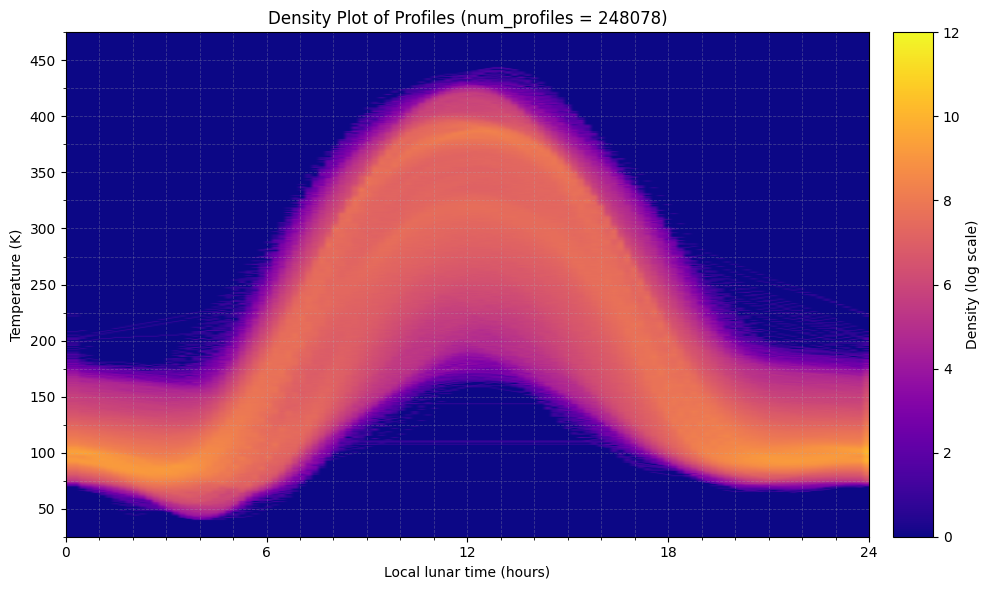

In [7]:
# * * * * * * * * * * * * * * * *
# Generate Density Plot
# * * * * * * * * * * * * * * * *
GenerateDensityPlot(temp_data, model_dir)

In [8]:
# * * * * * * * * * * * * * * * *
# Load Original Profile List
# * * * * * * * * * * * * * * * *
original_profile_list = LoadProfileList(ORIGINAL_PROFILE_LIST_JSON)

Saved figure to /workspace/outputs/profiles_v2_experiment_6_20250330_0143/histogram_max_temp.png


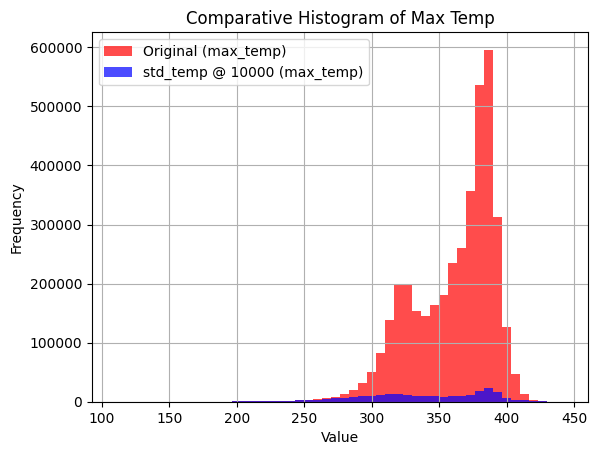

Saved figure to /workspace/outputs/profiles_v2_experiment_6_20250330_0143/histogram_min_temp.png


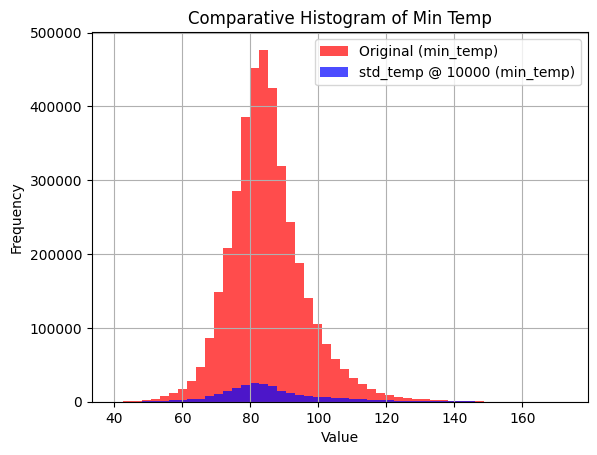

Saved figure to /workspace/outputs/profiles_v2_experiment_6_20250330_0143/histogram_mean_temp.png


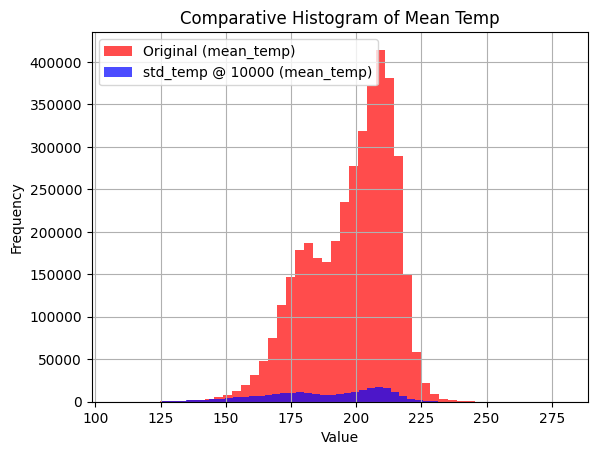

Saved figure to /workspace/outputs/profiles_v2_experiment_6_20250330_0143/histogram_std_temp.png


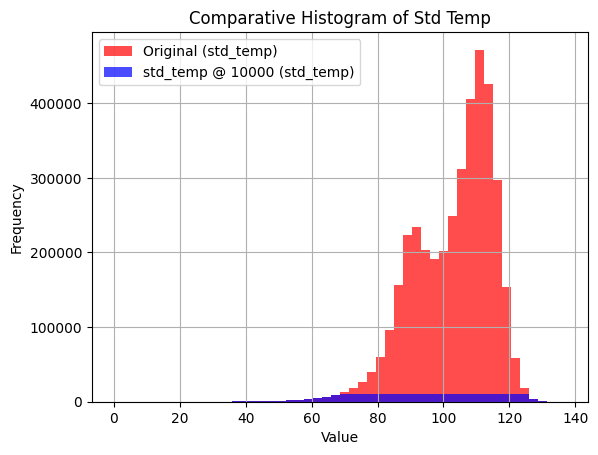

In [9]:
# * * * * * * * * * * * * * * * *
# Generate Histograms
# * * * * * * * * * * * * * * * *
statistics_original = CollectStatisticsFromProfilesV2(PROFILES_DIR, original_profile_list)
statistics_subset = CollectStatisticsFromProfilesV2(PROFILES_DIR, profile_list)
PlotComparativeHistograms(statistics_original, statistics_subset, labels=("Original", f"{TARGET_METRIC} @ {SAMPLE_SIZE}"), output_dir=model_dir)

In [10]:
# * * * * * * * * * * * * * * * *
# Training Log
# * * * * * * * * * * * * * * * 
log_filepath = os.path.join(model_dir, 'training.log')

# * * * * * * * * * * * * * * * *
# Data Prep
# * * * * * * * * * * * * * * * *
x_data_mean, x_data_std, x_data_min, x_data_max = GetDataMetrics(temp_data)

PrintAndLog(log_filepath, "Data Metrics:\n")
PrintAndLog(log_filepath, f"\tMean: {x_data_mean:.4f}\n")
PrintAndLog(log_filepath, f"\tSTD: {x_data_std:.4f}\n")
PrintAndLog(log_filepath, f"\tMin Temp: {x_data_min:.4f}\n")
PrintAndLog(log_filepath, f"\tMax Temp: {x_data_max:.4f}\n")

# Normalize Data (Mean=0, STD=1)
scaler = StandardScaler()
train_loader, val_loader, test_loader = SplitAndNormalizeData(
	temp_data, scaler, BATCH_SIZE, DEVICE)

PrintAndLog(log_filepath, "Datasets:\n")
PrintAndLog(
	log_filepath,
	f"\tTraining Data: {len(train_loader.dataset)}\n")
PrintAndLog(
	log_filepath,
	f"\tValidation Data: {len(val_loader.dataset)}\n")
PrintAndLog(log_filepath, f"\tTest Data: {len(test_loader.dataset)}\n")

Data Metrics:
Mean: 187.6493
STD: 97.3423
Min Temp: 40.0450
Max Temp: 443.4440
Datasets:
Training Data: 173654
Validation Data: 49615
Test Data: 24809


In [11]:
# * * * * * * * * * * * * * * * *
# VAE Setup
# * * * * * * * * * * * * * * * *
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=GAMMA)

summary(vae, input_size=(BATCH_SIZE, INPUT_DIM[0], INPUT_DIM[1]))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [200, 1, 120]             --
├─Encoder: 1-1                           [200, 4, 1]               --
│    └─Wrap1d: 2-1                       [200, 1, 122]             --
│    └─ConstantPad1d: 2-2                [200, 1, 128]             --
│    └─Conv1d: 2-3                       [200, 32, 128]            128
│    └─BatchNorm1d: 2-4                  [200, 32, 128]            64
│    └─Conv1d: 2-5                       [200, 32, 64]             2,080
│    └─BatchNorm1d: 2-6                  [200, 32, 64]             64
│    └─Conv1d: 2-7                       [200, 32, 32]             2,080
│    └─BatchNorm1d: 2-8                  [200, 32, 32]             64
│    └─Conv1d: 2-9                       [200, 32, 16]             2,080
│    └─BatchNorm1d: 2-10                 [200, 32, 16]             64
│    └─Conv1d: 2-11                      [200, 32, 8]              2,080
│ 

In [12]:
# * * * * * * * * * * * * * * * *
# Train and Validate
# * * * * * * * * * * * * * * * *
losses = train(
	vae, train_loader, val_loader,
	optimizer, scheduler, DEVICE, EPOCHS,
	BETA, model_dir)

[Training] Epoch 1/100: 100%|██████████| 869/869 [00:30<00:00, 28.60it/s, best_loss=0.8159]


[Training] Epoch 1/100, L1 Loss: 0.7990, L2 Loss: 1.0001, KL Loss: 0.0022, LR: 0.001000


[Validation] Epoch 1/100: 100%|██████████| 249/249 [00:02<00:00, 102.07it/s]


[Validation] Epoch 1/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v2_experiment_6_20250330_0143'


[Training] Epoch 2/100: 100%|██████████| 869/869 [00:30<00:00, 28.46it/s, best_loss=0.7903]


[Training] Epoch 2/100, L1 Loss: 0.7989, L2 Loss: 0.9999, KL Loss: 0.0001, LR: 0.000100


[Validation] Epoch 2/100: 100%|██████████| 249/249 [00:02<00:00, 87.74it/s] 


[Validation] Epoch 2/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 3/100: 100%|██████████| 869/869 [00:29<00:00, 29.41it/s, best_loss=0.8285]


[Training] Epoch 3/100, L1 Loss: 0.7990, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000010


[Validation] Epoch 3/100: 100%|██████████| 249/249 [00:02<00:00, 103.08it/s]


[Validation] Epoch 3/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 4/100: 100%|██████████| 869/869 [00:29<00:00, 29.28it/s, best_loss=0.8316]


[Training] Epoch 4/100, L1 Loss: 0.7990, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000001


[Validation] Epoch 4/100: 100%|██████████| 249/249 [00:02<00:00, 104.20it/s]


[Validation] Epoch 4/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 5/100: 100%|██████████| 869/869 [00:29<00:00, 29.23it/s, best_loss=0.8043]


[Training] Epoch 5/100, L1 Loss: 0.7990, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 5/100: 100%|██████████| 249/249 [00:02<00:00, 109.74it/s]


[Validation] Epoch 5/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 6/100: 100%|██████████| 869/869 [00:30<00:00, 28.90it/s, best_loss=0.8221]


[Training] Epoch 6/100, L1 Loss: 0.7989, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 6/100: 100%|██████████| 249/249 [00:02<00:00, 101.39it/s]


[Validation] Epoch 6/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 7/100: 100%|██████████| 869/869 [00:30<00:00, 28.71it/s, best_loss=0.8290]


[Training] Epoch 7/100, L1 Loss: 0.7989, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 7/100: 100%|██████████| 249/249 [00:02<00:00, 102.75it/s]


[Validation] Epoch 7/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 8/100: 100%|██████████| 869/869 [00:29<00:00, 29.14it/s, best_loss=0.8111]


[Training] Epoch 8/100, L1 Loss: 0.7990, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 8/100: 100%|██████████| 249/249 [00:02<00:00, 103.14it/s]


[Validation] Epoch 8/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 9/100: 100%|██████████| 869/869 [00:29<00:00, 29.21it/s, best_loss=0.8512]


[Training] Epoch 9/100, L1 Loss: 0.7989, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 9/100: 100%|██████████| 249/249 [00:02<00:00, 87.16it/s] 


[Validation] Epoch 9/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 10/100: 100%|██████████| 869/869 [00:30<00:00, 28.55it/s, best_loss=0.8587]


[Training] Epoch 10/100, L1 Loss: 0.7990, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 10/100: 100%|██████████| 249/249 [00:02<00:00, 94.13it/s]


[Validation] Epoch 10/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 11/100: 100%|██████████| 869/869 [00:31<00:00, 27.73it/s, best_loss=0.8310]


[Training] Epoch 11/100, L1 Loss: 0.7990, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 11/100: 100%|██████████| 249/249 [00:02<00:00, 102.81it/s]


[Validation] Epoch 11/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 12/100: 100%|██████████| 869/869 [00:31<00:00, 27.91it/s, best_loss=0.8319]


[Training] Epoch 12/100, L1 Loss: 0.7990, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 12/100: 100%|██████████| 249/249 [00:02<00:00, 104.52it/s]


[Validation] Epoch 12/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 13/100: 100%|██████████| 869/869 [00:30<00:00, 28.43it/s, best_loss=0.8080]


[Training] Epoch 13/100, L1 Loss: 0.7989, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 13/100: 100%|██████████| 249/249 [00:02<00:00, 98.87it/s] 


[Validation] Epoch 13/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 14/100: 100%|██████████| 869/869 [00:30<00:00, 28.62it/s, best_loss=0.8501]


[Training] Epoch 14/100, L1 Loss: 0.7990, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 14/100: 100%|██████████| 249/249 [00:02<00:00, 104.45it/s]


[Validation] Epoch 14/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 15/100: 100%|██████████| 869/869 [00:30<00:00, 28.93it/s, best_loss=0.8345]


[Training] Epoch 15/100, L1 Loss: 0.7990, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 15/100: 100%|██████████| 249/249 [00:02<00:00, 87.34it/s] 


[Validation] Epoch 15/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 16/100: 100%|██████████| 869/869 [00:29<00:00, 29.03it/s, best_loss=0.8327]


[Training] Epoch 16/100, L1 Loss: 0.7989, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 16/100: 100%|██████████| 249/249 [00:02<00:00, 103.44it/s]


[Validation] Epoch 16/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 17/100: 100%|██████████| 869/869 [00:30<00:00, 28.67it/s, best_loss=0.8349]


[Training] Epoch 17/100, L1 Loss: 0.7990, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 17/100: 100%|██████████| 249/249 [00:02<00:00, 102.31it/s]


[Validation] Epoch 17/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 18/100: 100%|██████████| 869/869 [00:30<00:00, 28.68it/s, best_loss=0.8367]


[Training] Epoch 18/100, L1 Loss: 0.7989, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 18/100: 100%|██████████| 249/249 [00:02<00:00, 103.19it/s]


[Validation] Epoch 18/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 19/100: 100%|██████████| 869/869 [00:30<00:00, 28.82it/s, best_loss=0.8396]


[Training] Epoch 19/100, L1 Loss: 0.7990, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 19/100: 100%|██████████| 249/249 [00:02<00:00, 100.82it/s]


[Validation] Epoch 19/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 20/100: 100%|██████████| 869/869 [00:30<00:00, 28.57it/s, best_loss=0.8465]


[Training] Epoch 20/100, L1 Loss: 0.7990, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 20/100: 100%|██████████| 249/249 [00:02<00:00, 99.73it/s] 


[Validation] Epoch 20/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 21/100: 100%|██████████| 869/869 [00:29<00:00, 29.04it/s, best_loss=0.8474]


[Training] Epoch 21/100, L1 Loss: 0.7990, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 21/100: 100%|██████████| 249/249 [00:02<00:00, 101.03it/s]


[Validation] Epoch 21/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 22/100: 100%|██████████| 869/869 [00:29<00:00, 29.37it/s, best_loss=0.8449]


[Training] Epoch 22/100, L1 Loss: 0.7990, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 22/100: 100%|██████████| 249/249 [00:02<00:00, 88.66it/s] 


[Validation] Epoch 22/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 23/100: 100%|██████████| 869/869 [00:29<00:00, 29.28it/s, best_loss=0.8393]


[Training] Epoch 23/100, L1 Loss: 0.7989, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 23/100: 100%|██████████| 249/249 [00:02<00:00, 102.29it/s]


[Validation] Epoch 23/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 24/100: 100%|██████████| 869/869 [00:30<00:00, 28.71it/s, best_loss=0.8271]


[Training] Epoch 24/100, L1 Loss: 0.7990, L2 Loss: 1.0000, KL Loss: 0.0001, LR: 0.000000


[Validation] Epoch 24/100: 100%|██████████| 249/249 [00:02<00:00, 101.11it/s]


[Validation] Epoch 24/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 25/100: 100%|██████████| 869/869 [00:30<00:00, 28.78it/s, best_loss=0.8224]


[Training] Epoch 25/100, L1 Loss: 0.7990, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 25/100: 100%|██████████| 249/249 [00:02<00:00, 101.61it/s]


[Validation] Epoch 25/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 26/100: 100%|██████████| 869/869 [00:30<00:00, 28.75it/s, best_loss=0.8052]


[Training] Epoch 26/100, L1 Loss: 0.7989, L2 Loss: 0.9998, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 26/100: 100%|██████████| 249/249 [00:02<00:00, 102.54it/s]


[Validation] Epoch 26/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 27/100: 100%|██████████| 869/869 [00:30<00:00, 28.75it/s, best_loss=0.8135]


[Training] Epoch 27/100, L1 Loss: 0.7990, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 27/100: 100%|██████████| 249/249 [00:02<00:00, 101.93it/s]


[Validation] Epoch 27/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 28/100: 100%|██████████| 869/869 [00:30<00:00, 28.54it/s, best_loss=0.8103]


[Training] Epoch 28/100, L1 Loss: 0.7989, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 28/100: 100%|██████████| 249/249 [00:02<00:00, 102.20it/s]


[Validation] Epoch 28/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 29/100: 100%|██████████| 869/869 [00:29<00:00, 29.12it/s, best_loss=0.8173]


[Training] Epoch 29/100, L1 Loss: 0.7989, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 29/100: 100%|██████████| 249/249 [00:02<00:00, 87.92it/s] 


[Validation] Epoch 29/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 30/100: 100%|██████████| 869/869 [00:29<00:00, 29.15it/s, best_loss=0.8450]


[Training] Epoch 30/100, L1 Loss: 0.7990, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 30/100: 100%|██████████| 249/249 [00:02<00:00, 105.01it/s]


[Validation] Epoch 30/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 31/100: 100%|██████████| 869/869 [00:30<00:00, 28.75it/s, best_loss=0.8399]


[Training] Epoch 31/100, L1 Loss: 0.7990, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 31/100: 100%|██████████| 249/249 [00:02<00:00, 104.23it/s]


[Validation] Epoch 31/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 32/100: 100%|██████████| 869/869 [00:30<00:00, 28.65it/s, best_loss=0.8315]


[Training] Epoch 32/100, L1 Loss: 0.7990, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 32/100: 100%|██████████| 249/249 [00:02<00:00, 102.91it/s]


[Validation] Epoch 32/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 33/100: 100%|██████████| 869/869 [00:30<00:00, 28.81it/s, best_loss=0.8364]


[Training] Epoch 33/100, L1 Loss: 0.7990, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 33/100: 100%|██████████| 249/249 [00:02<00:00, 101.18it/s]


[Validation] Epoch 33/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 34/100: 100%|██████████| 869/869 [00:30<00:00, 28.61it/s, best_loss=0.8302]


[Training] Epoch 34/100, L1 Loss: 0.7989, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 34/100: 100%|██████████| 249/249 [00:02<00:00, 101.14it/s]


[Validation] Epoch 34/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 35/100: 100%|██████████| 869/869 [00:30<00:00, 28.30it/s, best_loss=0.8215]


[Training] Epoch 35/100, L1 Loss: 0.7989, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 35/100: 100%|██████████| 249/249 [00:02<00:00, 83.60it/s]


[Validation] Epoch 35/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 36/100: 100%|██████████| 869/869 [00:30<00:00, 28.70it/s, best_loss=0.8300]


[Training] Epoch 36/100, L1 Loss: 0.7990, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 36/100: 100%|██████████| 249/249 [00:02<00:00, 86.19it/s] 


[Validation] Epoch 36/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 37/100: 100%|██████████| 869/869 [00:30<00:00, 28.59it/s, best_loss=0.7821]


[Training] Epoch 37/100, L1 Loss: 0.7990, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 37/100: 100%|██████████| 249/249 [00:02<00:00, 89.98it/s]


[Validation] Epoch 37/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 38/100: 100%|██████████| 869/869 [00:31<00:00, 27.60it/s, best_loss=0.8447]


[Training] Epoch 38/100, L1 Loss: 0.7990, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 38/100: 100%|██████████| 249/249 [00:02<00:00, 99.32it/s] 


[Validation] Epoch 38/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 39/100: 100%|██████████| 869/869 [00:30<00:00, 28.51it/s, best_loss=0.8462]


[Training] Epoch 39/100, L1 Loss: 0.7990, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 39/100: 100%|██████████| 249/249 [00:02<00:00, 102.82it/s]


[Validation] Epoch 39/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 40/100: 100%|██████████| 869/869 [00:30<00:00, 28.80it/s, best_loss=0.7914]


[Training] Epoch 40/100, L1 Loss: 0.7990, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 40/100: 100%|██████████| 249/249 [00:02<00:00, 101.61it/s]


[Validation] Epoch 40/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 41/100: 100%|██████████| 869/869 [00:30<00:00, 28.52it/s, best_loss=0.8138]


[Training] Epoch 41/100, L1 Loss: 0.7990, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 41/100: 100%|██████████| 249/249 [00:02<00:00, 104.06it/s]


[Validation] Epoch 41/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 42/100: 100%|██████████| 869/869 [00:29<00:00, 29.20it/s, best_loss=0.8008]


[Training] Epoch 42/100, L1 Loss: 0.7989, L2 Loss: 0.9998, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 42/100: 100%|██████████| 249/249 [00:02<00:00, 86.78it/s] 


[Validation] Epoch 42/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 43/100: 100%|██████████| 869/869 [00:29<00:00, 29.20it/s, best_loss=0.8552]


[Training] Epoch 43/100, L1 Loss: 0.7990, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 43/100: 100%|██████████| 249/249 [00:02<00:00, 104.09it/s]


[Validation] Epoch 43/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 44/100: 100%|██████████| 869/869 [00:30<00:00, 28.87it/s, best_loss=0.8312]


[Training] Epoch 44/100, L1 Loss: 0.7990, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 44/100: 100%|██████████| 249/249 [00:02<00:00, 102.14it/s]


[Validation] Epoch 44/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 45/100: 100%|██████████| 869/869 [00:30<00:00, 28.67it/s, best_loss=0.8208]


[Training] Epoch 45/100, L1 Loss: 0.7991, L2 Loss: 1.0003, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 45/100: 100%|██████████| 249/249 [00:02<00:00, 101.85it/s]


[Validation] Epoch 45/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 46/100: 100%|██████████| 869/869 [00:30<00:00, 28.76it/s, best_loss=0.8312]


[Training] Epoch 46/100, L1 Loss: 0.7990, L2 Loss: 1.0002, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 46/100: 100%|██████████| 249/249 [00:02<00:00, 101.24it/s]


[Validation] Epoch 46/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 47/100: 100%|██████████| 869/869 [00:30<00:00, 28.66it/s, best_loss=0.8070]


[Training] Epoch 47/100, L1 Loss: 0.7989, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 47/100: 100%|██████████| 249/249 [00:02<00:00, 104.52it/s]


[Validation] Epoch 47/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 48/100: 100%|██████████| 869/869 [00:30<00:00, 28.81it/s, best_loss=0.8301]


[Training] Epoch 48/100, L1 Loss: 0.7990, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 48/100: 100%|██████████| 249/249 [00:02<00:00, 100.91it/s]


[Validation] Epoch 48/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 49/100: 100%|██████████| 869/869 [00:30<00:00, 28.69it/s, best_loss=0.8036]


[Training] Epoch 49/100, L1 Loss: 0.7989, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 49/100: 100%|██████████| 249/249 [00:02<00:00, 87.92it/s] 


[Validation] Epoch 49/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 50/100: 100%|██████████| 869/869 [00:30<00:00, 28.45it/s, best_loss=0.8503]


[Training] Epoch 50/100, L1 Loss: 0.7990, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 50/100: 100%|██████████| 249/249 [00:02<00:00, 102.19it/s]


[Validation] Epoch 50/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 51/100: 100%|██████████| 869/869 [00:30<00:00, 28.04it/s, best_loss=0.8394]


[Training] Epoch 51/100, L1 Loss: 0.7990, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 51/100: 100%|██████████| 249/249 [00:02<00:00, 105.03it/s]


[Validation] Epoch 51/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 52/100: 100%|██████████| 869/869 [00:30<00:00, 28.80it/s, best_loss=0.7950]


[Training] Epoch 52/100, L1 Loss: 0.7990, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 52/100: 100%|██████████| 249/249 [00:02<00:00, 99.89it/s] 


[Validation] Epoch 52/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 53/100: 100%|██████████| 869/869 [00:30<00:00, 28.44it/s, best_loss=0.8382]


[Training] Epoch 53/100, L1 Loss: 0.7990, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 53/100: 100%|██████████| 249/249 [00:02<00:00, 102.43it/s]


[Validation] Epoch 53/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 54/100: 100%|██████████| 869/869 [00:29<00:00, 28.97it/s, best_loss=0.8486]


[Training] Epoch 54/100, L1 Loss: 0.7990, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 54/100: 100%|██████████| 249/249 [00:02<00:00, 102.37it/s]


[Validation] Epoch 54/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 55/100: 100%|██████████| 869/869 [00:29<00:00, 29.28it/s, best_loss=0.8334]


[Training] Epoch 55/100, L1 Loss: 0.7990, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 55/100: 100%|██████████| 249/249 [00:02<00:00, 88.05it/s] 


[Validation] Epoch 55/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 56/100: 100%|██████████| 869/869 [00:30<00:00, 28.17it/s, best_loss=0.8358]


[Training] Epoch 56/100, L1 Loss: 0.7990, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 56/100: 100%|██████████| 249/249 [00:02<00:00, 89.64it/s] 


[Validation] Epoch 56/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 57/100: 100%|██████████| 869/869 [00:30<00:00, 28.93it/s, best_loss=0.8422]


[Training] Epoch 57/100, L1 Loss: 0.7990, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 57/100: 100%|██████████| 249/249 [00:02<00:00, 107.77it/s]


[Validation] Epoch 57/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 58/100: 100%|██████████| 869/869 [00:30<00:00, 28.94it/s, best_loss=0.8088]


[Training] Epoch 58/100, L1 Loss: 0.7990, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 58/100: 100%|██████████| 249/249 [00:02<00:00, 108.54it/s]


[Validation] Epoch 58/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 59/100: 100%|██████████| 869/869 [00:30<00:00, 28.21it/s, best_loss=0.8568]


[Training] Epoch 59/100, L1 Loss: 0.7989, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 59/100: 100%|██████████| 249/249 [00:02<00:00, 101.57it/s]


[Validation] Epoch 59/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 60/100: 100%|██████████| 869/869 [00:30<00:00, 28.23it/s, best_loss=0.8477]


[Training] Epoch 60/100, L1 Loss: 0.7990, L2 Loss: 1.0002, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 60/100: 100%|██████████| 249/249 [00:02<00:00, 102.13it/s]


[Validation] Epoch 60/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 61/100: 100%|██████████| 869/869 [00:29<00:00, 29.06it/s, best_loss=0.8413]


[Training] Epoch 61/100, L1 Loss: 0.7989, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 61/100: 100%|██████████| 249/249 [00:02<00:00, 105.23it/s]


[Validation] Epoch 61/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 62/100: 100%|██████████| 869/869 [00:30<00:00, 28.68it/s, best_loss=0.8557]


[Training] Epoch 62/100, L1 Loss: 0.7990, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 62/100: 100%|██████████| 249/249 [00:02<00:00, 90.00it/s] 


[Validation] Epoch 62/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 63/100: 100%|██████████| 869/869 [00:30<00:00, 28.65it/s, best_loss=0.7971]


[Training] Epoch 63/100, L1 Loss: 0.7989, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 63/100: 100%|██████████| 249/249 [00:02<00:00, 103.65it/s]


[Validation] Epoch 63/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 64/100: 100%|██████████| 869/869 [00:30<00:00, 28.59it/s, best_loss=0.8539]


[Training] Epoch 64/100, L1 Loss: 0.7990, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 64/100: 100%|██████████| 249/249 [00:02<00:00, 105.40it/s]


[Validation] Epoch 64/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 65/100: 100%|██████████| 869/869 [00:30<00:00, 28.24it/s, best_loss=0.8422]


[Training] Epoch 65/100, L1 Loss: 0.7990, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 65/100: 100%|██████████| 249/249 [00:02<00:00, 102.97it/s]


[Validation] Epoch 65/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 66/100: 100%|██████████| 869/869 [00:30<00:00, 28.80it/s, best_loss=0.8526]


[Training] Epoch 66/100, L1 Loss: 0.7990, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 66/100: 100%|██████████| 249/249 [00:02<00:00, 105.25it/s]


[Validation] Epoch 66/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 67/100: 100%|██████████| 869/869 [00:30<00:00, 28.43it/s, best_loss=0.8344]


[Training] Epoch 67/100, L1 Loss: 0.7990, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 67/100: 100%|██████████| 249/249 [00:02<00:00, 102.56it/s]


[Validation] Epoch 67/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 68/100: 100%|██████████| 869/869 [00:30<00:00, 28.42it/s, best_loss=0.8207]


[Training] Epoch 68/100, L1 Loss: 0.7989, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 68/100: 100%|██████████| 249/249 [00:02<00:00, 100.09it/s]


[Validation] Epoch 68/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 69/100: 100%|██████████| 869/869 [00:30<00:00, 28.59it/s, best_loss=0.8421]


[Training] Epoch 69/100, L1 Loss: 0.7990, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 69/100: 100%|██████████| 249/249 [00:02<00:00, 90.47it/s] 


[Validation] Epoch 69/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 70/100: 100%|██████████| 869/869 [00:30<00:00, 28.22it/s, best_loss=0.8308]


[Training] Epoch 70/100, L1 Loss: 0.7989, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 70/100: 100%|██████████| 249/249 [00:02<00:00, 96.61it/s]


[Validation] Epoch 70/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 71/100: 100%|██████████| 869/869 [00:30<00:00, 28.31it/s, best_loss=0.8515]


[Training] Epoch 71/100, L1 Loss: 0.7989, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 71/100: 100%|██████████| 249/249 [00:02<00:00, 102.91it/s]


[Validation] Epoch 71/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 72/100: 100%|██████████| 869/869 [00:30<00:00, 28.52it/s, best_loss=0.8374]


[Training] Epoch 72/100, L1 Loss: 0.7990, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 72/100: 100%|██████████| 249/249 [00:02<00:00, 98.18it/s] 


[Validation] Epoch 72/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 73/100: 100%|██████████| 869/869 [00:30<00:00, 28.09it/s, best_loss=0.8176]


[Training] Epoch 73/100, L1 Loss: 0.7989, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 73/100: 100%|██████████| 249/249 [00:02<00:00, 99.40it/s] 


[Validation] Epoch 73/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 74/100: 100%|██████████| 869/869 [00:30<00:00, 28.62it/s, best_loss=0.8406]


[Training] Epoch 74/100, L1 Loss: 0.7990, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 74/100: 100%|██████████| 249/249 [00:02<00:00, 103.56it/s]


[Validation] Epoch 74/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 75/100: 100%|██████████| 869/869 [00:30<00:00, 28.64it/s, best_loss=0.8395]


[Training] Epoch 75/100, L1 Loss: 0.7990, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 75/100: 100%|██████████| 249/249 [00:02<00:00, 101.10it/s]


[Validation] Epoch 75/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 76/100: 100%|██████████| 869/869 [00:30<00:00, 28.80it/s, best_loss=0.8534]


[Training] Epoch 76/100, L1 Loss: 0.7990, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 76/100: 100%|██████████| 249/249 [00:02<00:00, 91.85it/s] 


[Validation] Epoch 76/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 77/100: 100%|██████████| 869/869 [00:30<00:00, 28.38it/s, best_loss=0.8485]


[Training] Epoch 77/100, L1 Loss: 0.7990, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 77/100: 100%|██████████| 249/249 [00:02<00:00, 99.72it/s] 


[Validation] Epoch 77/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 78/100: 100%|██████████| 869/869 [00:30<00:00, 28.27it/s, best_loss=0.8481]


[Training] Epoch 78/100, L1 Loss: 0.7990, L2 Loss: 1.0002, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 78/100: 100%|██████████| 249/249 [00:02<00:00, 101.94it/s]


[Validation] Epoch 78/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 79/100: 100%|██████████| 869/869 [00:30<00:00, 28.17it/s, best_loss=0.8353]


[Training] Epoch 79/100, L1 Loss: 0.7990, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 79/100: 100%|██████████| 249/249 [00:02<00:00, 96.10it/s]


[Validation] Epoch 79/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 80/100: 100%|██████████| 869/869 [00:30<00:00, 28.24it/s, best_loss=0.8124]


[Training] Epoch 80/100, L1 Loss: 0.7990, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 80/100: 100%|██████████| 249/249 [00:02<00:00, 95.96it/s] 


[Validation] Epoch 80/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 81/100: 100%|██████████| 869/869 [00:30<00:00, 28.39it/s, best_loss=0.8466]


[Training] Epoch 81/100, L1 Loss: 0.7990, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 81/100: 100%|██████████| 249/249 [00:02<00:00, 106.24it/s]


[Validation] Epoch 81/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 82/100: 100%|██████████| 869/869 [00:30<00:00, 28.91it/s, best_loss=0.8220]


[Training] Epoch 82/100, L1 Loss: 0.7990, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 82/100: 100%|██████████| 249/249 [00:02<00:00, 83.10it/s]


[Validation] Epoch 82/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 83/100: 100%|██████████| 869/869 [00:30<00:00, 28.96it/s, best_loss=0.8508]


[Training] Epoch 83/100, L1 Loss: 0.7990, L2 Loss: 1.0002, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 83/100: 100%|██████████| 249/249 [00:02<00:00, 86.40it/s] 


[Validation] Epoch 83/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 84/100: 100%|██████████| 869/869 [00:30<00:00, 28.47it/s, best_loss=0.8323]


[Training] Epoch 84/100, L1 Loss: 0.7990, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 84/100: 100%|██████████| 249/249 [00:02<00:00, 102.71it/s]


[Validation] Epoch 84/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 85/100: 100%|██████████| 869/869 [00:30<00:00, 28.87it/s, best_loss=0.8479]


[Training] Epoch 85/100, L1 Loss: 0.7990, L2 Loss: 1.0002, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 85/100: 100%|██████████| 249/249 [00:02<00:00, 107.17it/s]


[Validation] Epoch 85/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 86/100: 100%|██████████| 869/869 [00:30<00:00, 28.87it/s, best_loss=0.8368]


[Training] Epoch 86/100, L1 Loss: 0.7990, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 86/100: 100%|██████████| 249/249 [00:02<00:00, 106.72it/s]


[Validation] Epoch 86/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 87/100: 100%|██████████| 869/869 [00:30<00:00, 28.63it/s, best_loss=0.8094]


[Training] Epoch 87/100, L1 Loss: 0.7990, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 87/100: 100%|██████████| 249/249 [00:02<00:00, 99.82it/s] 


[Validation] Epoch 87/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 88/100: 100%|██████████| 869/869 [00:30<00:00, 28.41it/s, best_loss=0.8104]


[Training] Epoch 88/100, L1 Loss: 0.7990, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 88/100: 100%|██████████| 249/249 [00:02<00:00, 98.86it/s] 


[Validation] Epoch 88/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 89/100: 100%|██████████| 869/869 [00:30<00:00, 28.77it/s, best_loss=0.8402]


[Training] Epoch 89/100, L1 Loss: 0.7990, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 89/100: 100%|██████████| 249/249 [00:02<00:00, 86.40it/s] 


[Validation] Epoch 89/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 90/100: 100%|██████████| 869/869 [00:30<00:00, 28.54it/s, best_loss=0.8393]


[Training] Epoch 90/100, L1 Loss: 0.7990, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 90/100: 100%|██████████| 249/249 [00:02<00:00, 98.14it/s]


[Validation] Epoch 90/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 91/100: 100%|██████████| 869/869 [00:31<00:00, 27.99it/s, best_loss=0.8439]


[Training] Epoch 91/100, L1 Loss: 0.7989, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 91/100: 100%|██████████| 249/249 [00:02<00:00, 99.60it/s] 


[Validation] Epoch 91/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 92/100: 100%|██████████| 869/869 [00:31<00:00, 27.81it/s, best_loss=0.8362]


[Training] Epoch 92/100, L1 Loss: 0.7989, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 92/100: 100%|██████████| 249/249 [00:02<00:00, 102.02it/s]


[Validation] Epoch 92/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 93/100: 100%|██████████| 869/869 [00:31<00:00, 28.01it/s, best_loss=0.8233]


[Training] Epoch 93/100, L1 Loss: 0.7990, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 93/100: 100%|██████████| 249/249 [00:02<00:00, 103.25it/s]


[Validation] Epoch 93/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 94/100: 100%|██████████| 869/869 [00:30<00:00, 28.31it/s, best_loss=0.8269]


[Training] Epoch 94/100, L1 Loss: 0.7990, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 94/100: 100%|██████████| 249/249 [00:02<00:00, 102.65it/s]


[Validation] Epoch 94/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 95/100: 100%|██████████| 869/869 [00:30<00:00, 28.04it/s, best_loss=0.8417]


[Training] Epoch 95/100, L1 Loss: 0.7989, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 95/100: 100%|██████████| 249/249 [00:02<00:00, 102.47it/s]


[Validation] Epoch 95/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 96/100: 100%|██████████| 869/869 [00:30<00:00, 28.77it/s, best_loss=0.8474]


[Training] Epoch 96/100, L1 Loss: 0.7990, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 96/100: 100%|██████████| 249/249 [00:02<00:00, 90.23it/s] 


[Validation] Epoch 96/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 97/100: 100%|██████████| 869/869 [00:30<00:00, 28.92it/s, best_loss=0.7999]


[Training] Epoch 97/100, L1 Loss: 0.7989, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 97/100: 100%|██████████| 249/249 [00:02<00:00, 101.43it/s]


[Validation] Epoch 97/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 98/100: 100%|██████████| 869/869 [00:30<00:00, 28.21it/s, best_loss=0.8507]


[Training] Epoch 98/100, L1 Loss: 0.7990, L2 Loss: 1.0001, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 98/100: 100%|██████████| 249/249 [00:02<00:00, 99.76it/s] 


[Validation] Epoch 98/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 99/100: 100%|██████████| 869/869 [00:30<00:00, 28.49it/s, best_loss=0.8371]


[Training] Epoch 99/100, L1 Loss: 0.7990, L2 Loss: 1.0000, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 99/100: 100%|██████████| 249/249 [00:02<00:00, 101.22it/s]


[Validation] Epoch 99/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


[Training] Epoch 100/100: 100%|██████████| 869/869 [00:30<00:00, 28.57it/s, best_loss=0.8312]


[Training] Epoch 100/100, L1 Loss: 0.7989, L2 Loss: 0.9999, KL Loss: 0.0000, LR: 0.000000


[Validation] Epoch 100/100: 100%|██████████| 249/249 [00:02<00:00, 98.83it/s] 

[Validation] Epoch 100/100, Val L1 Loss: 0.7985, Val L2 Loss: 1.0000, Val KL Loss: 0.0000


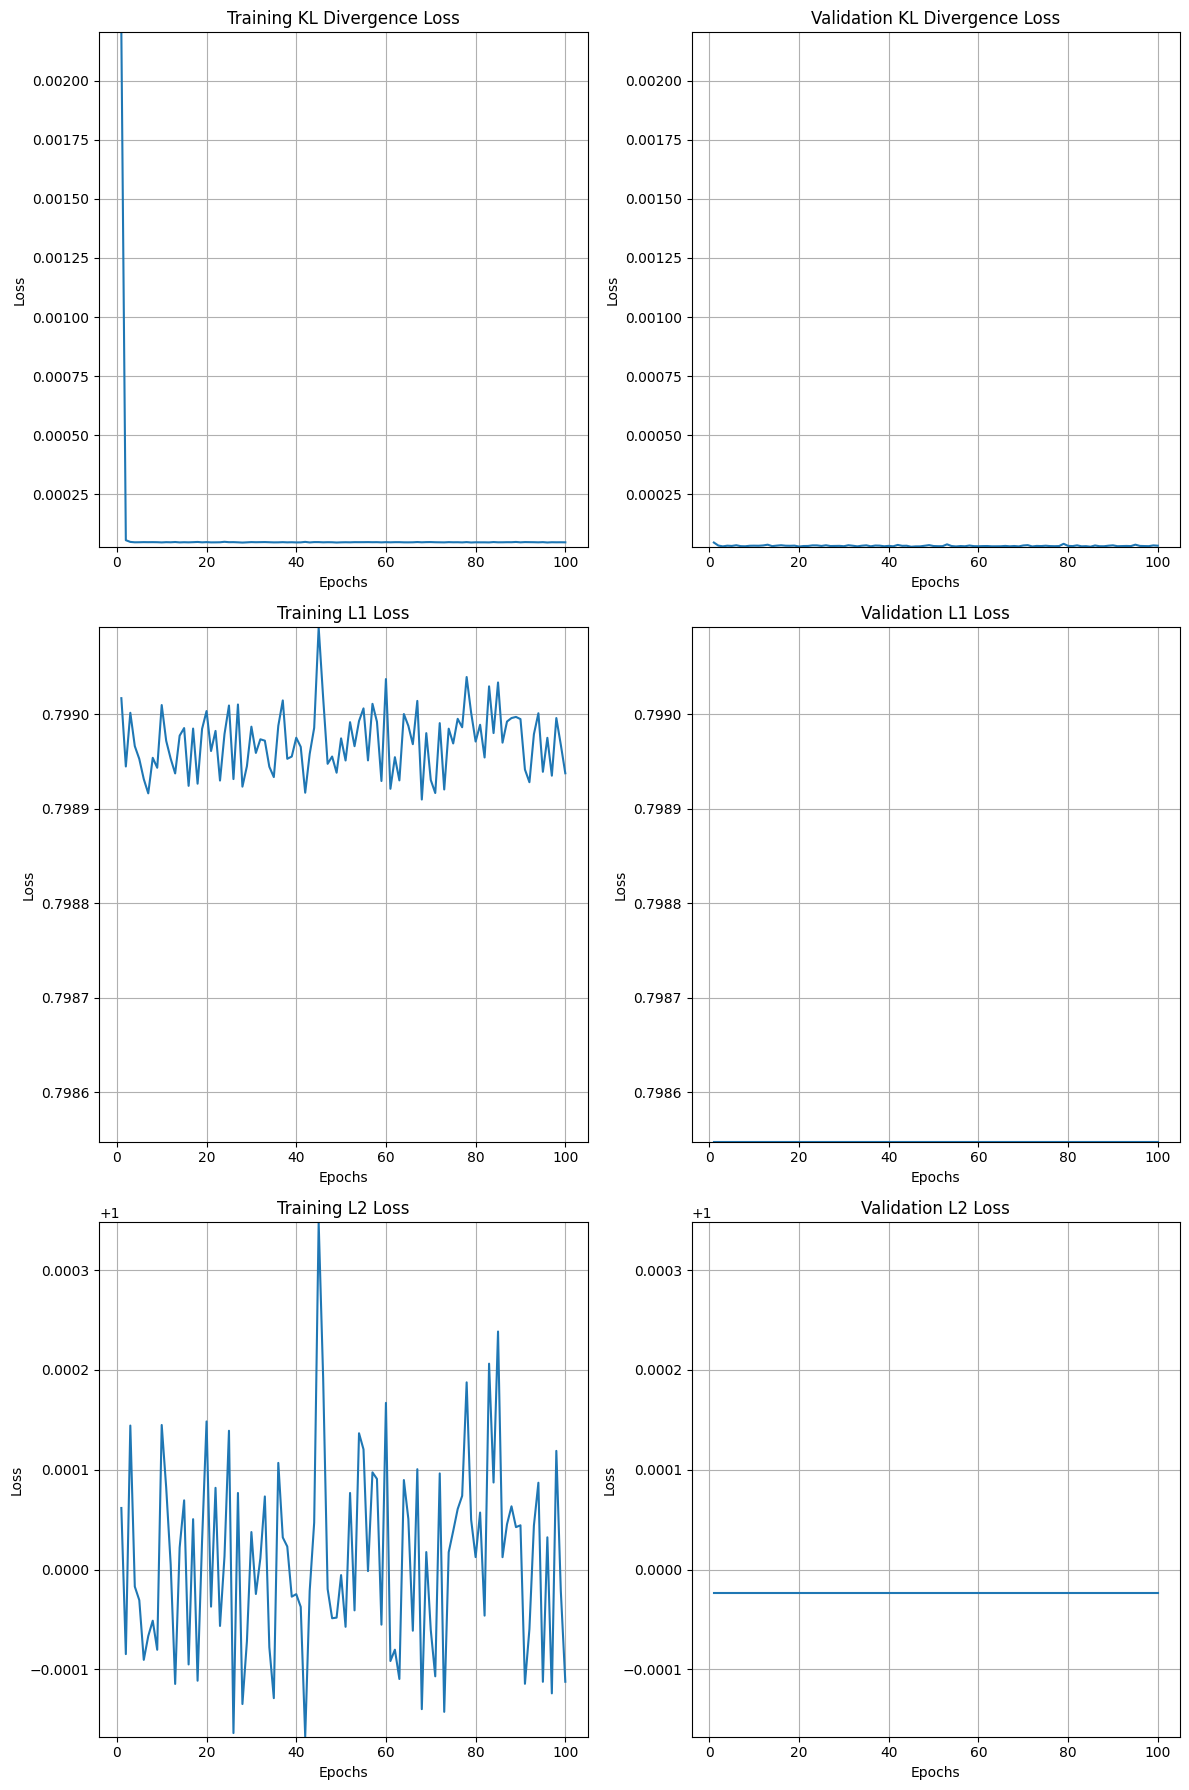

In [13]:
# * * * * * * * * * * * * * * * *
# Plot Losses
# * * * * * * * * * * * * * * * *
PlotLosses(losses, EPOCHS, model_dir)
SaveLossesToCSV(losses, os.path.join(model_dir, "losses.csv"))

In [14]:
# * * * * * * * * * * * * * * * *
# Best Validation Loss
# * * * * * * * * * * * * * * * *
PrintAndLog(log_filepath, "Best Validation Loss in Kelvins:\n")
PrintAndLog(
	log_filepath,
	f"\t{min(losses['val_l1_losses'])*x_data_std:.4f} K\n")

Best Validation Loss in Kelvins:
77.7325 K


In [15]:
# * * * * * * * * * * * * * * * *
# Sample
# * * * * * * * * * * * * * * * *
z_sample = SampleLatentSpace(
	vae,
	test_loader,
	scaler,
	DEVICE,
	model_dir
)

[Sampling]: 100%|██████████| 13/13 [00:13<00:00,  1.00s/it]


z0: -0.0001
z1: 0.0005
z2: 0.0009
z3: -0.0000


Traversing Latent Dimension z3: 100%|██████████| 11/11 [00:00<00:00, 642.89it/s]


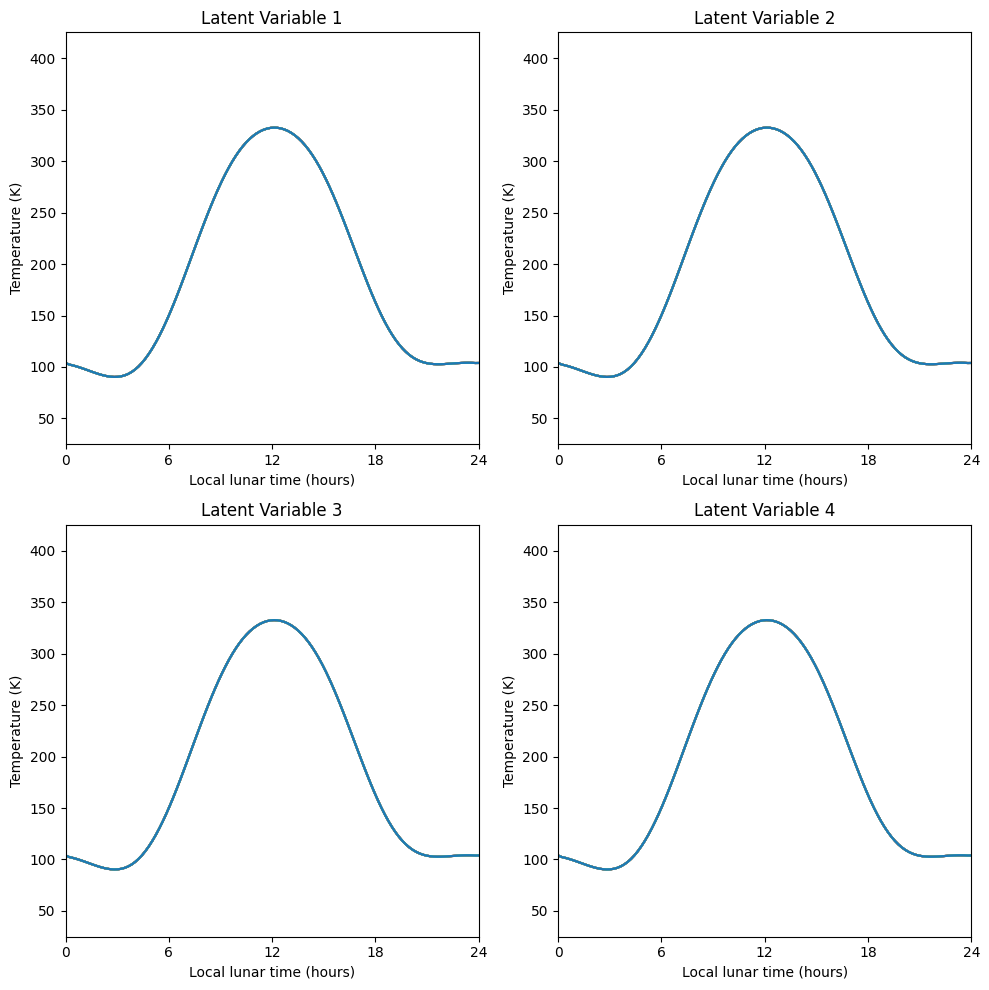

In [16]:
# * * * * * * * * * * * * * * * *
# Analyze Latent Space
# * * * * * * * * * * * * * * * *
mean_latent_vals = GetMeanLatentValues(z_sample, LATENT_DIM)
for i in range(LATENT_DIM):
	print(f"z{i}: {mean_latent_vals[i]:.4f}")

VisualizeLatentSpace(
	vae, LATENT_DIM, z_sample,
	scaler, DEVICE, model_dir)